In [142]:
import  numpy as np
import pandas as pd
import  matplotlib.pyplot as plt
import  seaborn as sns

from sklearn.datasets import make_circles

import torch
import torch.nn as nn
from torch.optim import SGD
from torch.nn import BCEWithLogitsLoss  #combine (sigmoid and BCEloss)
import  torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [143]:
sample =1000

X,y = make_circles(n_samples=sample,noise=0.05,random_state=42)


In [144]:
X.shape ,y.shape

((1000, 2), (1000,))

In [145]:
X,y[:5]

(array([[ 0.74220688,  0.24668576],
        [-0.7340323 ,  0.16869164],
        [-0.82985872,  0.22195899],
        ...,
        [-0.12823057, -0.82613318],
        [ 0.66090453, -0.79319015],
        [ 0.27841491,  0.96735953]]),
 array([1, 1, 1, 1, 0]))

In [146]:
df= pd.DataFrame({"X1":X[:,0],
                  "X2":X[:,1],
                  "label":y})

In [147]:
df.head()

,X1,X2,label
0,0.742207,0.246686,1
1,-0.734032,0.168692,1
2,-0.829859,0.221959,1
3,-0.429136,0.672230,1
4,0.445602,-0.894936,0


<Axes: xlabel='X1', ylabel='X2'>

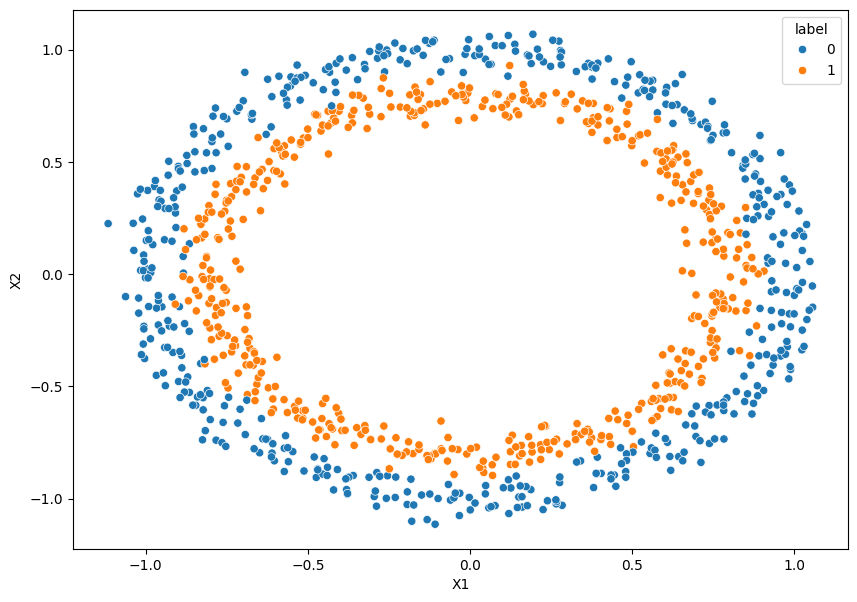

In [148]:
plt.figure(figsize=(10,7))
sns.scatterplot(x="X1",y="X2",hue="label",data=df)

In [149]:
X=torch.tensor(X,dtype=torch.float)
y=torch.tensor(y,dtype=torch.float)

In [150]:
type(X),type(y)

(torch.Tensor, torch.Tensor)

In [151]:
# X=torch.from_numpy(X).type(torch.float)
# y=torch.from_numpy(y).type(torch.float)

In [152]:
type(X),type(y)

(torch.Tensor, torch.Tensor)

In [153]:
# split


X_train , X_test , y_train , y_test = train_test_split( X,y,test_size=0.2,random_state=42)

In [154]:
len(X_train) , len(y_train) , len(X_test) , len(y_test)


(800, 800, 200, 200)

In [155]:
device = "CUDA" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [156]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2,out_features=5)
        self.layer_2 = nn.Linear(in_features=5,out_features=1)

    def forward(self,x):
      return self.layer_2((self.layer_1(x)))


In [157]:
model_0 = CircleModelV0().to(device)
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]])),
             ('layer_1.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410])),
             ('layer_2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]])),
             ('layer_2.bias', tensor([-0.2060]))])

In [158]:
type(model_0.parameters())

generator

In [159]:
# # or use Sequential
# model_0 = nn.Sequential(
#     nn.Linear(in_features=2,out_features=5),
#     nn.Linear(in_features=5,out_features=1)
# )

In [160]:
type(X_test)

torch.Tensor

In [161]:
"""
X_test -> y_test
"""

untrained_preds = model_0(X_test.to(device))

print(f"this is the shape of the untrained models predictions : {untrained_preds.shape}")
print(f"this is the real targets shape : {y_test.shape}")

this is the shape of the untrained models predictions : torch.Size([200, 1])
this is the real targets shape : torch.Size([200])


In [162]:
print(f"this is the untrained model predictions : {untrained_preds[:5]}")
# if we use torch.round we would get something similar to the real targets
print(f"this is the real targets : {y_test[:5]} ")

this is the untrained model predictions : tensor([[-0.1268],
        [-0.0962],
        [-0.1896],
        [-0.1068],
        [-0.1697]], grad_fn=<SliceBackward0>)
this is the real targets : tensor([1., 0., 1., 0., 1.]) 


# workflow


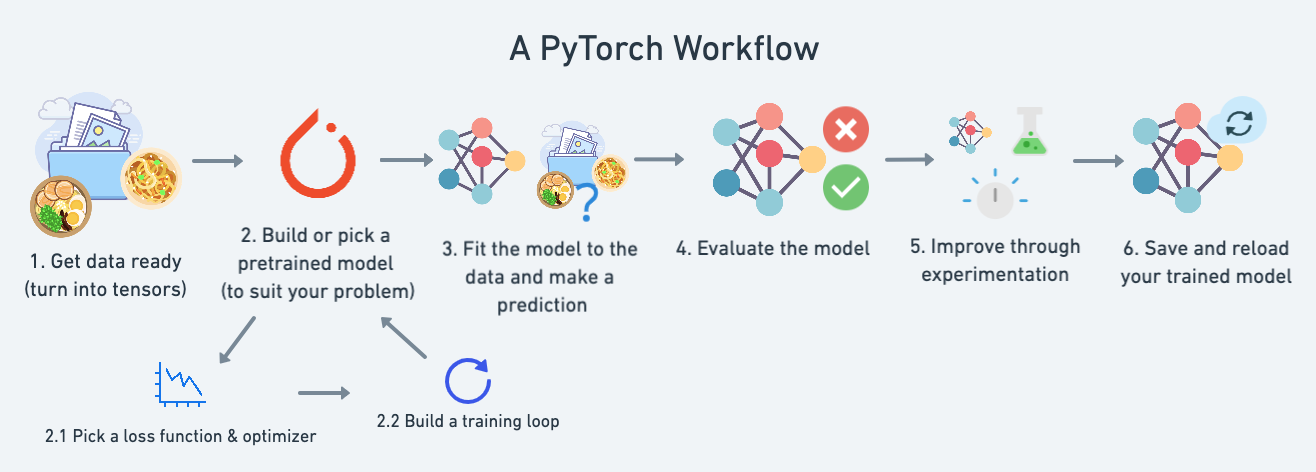

In [163]:
"""
    so our problem is a classification problem,
    so our problem is a Binary classification problem,
    classification problem loss functions are :

    1. BCEloss() -> binary problems

    2. BCEWithLogitLoss() -> binary problems -> (sigmoid() , BCEloss()) -> we choose this because its numerically stable
        if we look inside we will find something like this -> nn.Sequential(nn.Sigmoid(),nn.BCELoss())

    3. CategoricalCrossEntropy() -> multi class classification

"""
loss_fn = BCEWithLogitsLoss()
optimizer = SGD(model_0.parameters(),lr=0.01)


In [164]:
random_tensor = torch.tensor([-100,-5,-1,-0.5,0,0.5,1,5,100])
sigmoid_output = torch.sigmoid(random_tensor)
sigmoid_output

tensor([0.0000, 0.0067, 0.2689, 0.3775, 0.5000, 0.6225, 0.7311, 0.9933, 1.0000])

In [165]:
untrained_preds[:5]

tensor([[-0.1268],
        [-0.0962],
        [-0.1896],
        [-0.1068],
        [-0.1697]], grad_fn=<SliceBackward0>)

In [166]:
sigmoid_output_2 = torch.sigmoid(untrained_preds[:5])
sigmoid_output_2

tensor([[0.4683],
        [0.4760],
        [0.4527],
        [0.4733],
        [0.4577]], grad_fn=<SigmoidBackward0>)

In [167]:
output_after_sigmoid = torch.round(sigmoid_output_2)
output_after_sigmoid

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<RoundBackward0>)

In [168]:
"""
tensor = [1,1,1,1,1] -> this is the output of the model
ground truth tensor = [1,0,1,1,0]

acc = 2/5 -> 60 % acc
"""

'\ntensor = [1,1,1,1,1] -> this is the output of the model\nground truth tensor = [1,0,1,1,0]\n\nacc = 2/5 -> 60 % acc\n'

In [169]:
def accuracy_function(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = correct/len(y_pred)
  return acc

In [170]:
x_p = torch.tensor([1,1,1,1,1])
x_t = torch.tensor([1,1,1,1,1])



In [171]:
accuracy_function(x_p,x_t)

1.0

# logits : prediction before activation

* logits -> preds prob -> round preds labels
* binary classification we use sigmoid
* multi class classification we use softmax

# Let's Construct a training loop


# Steps

* Forward pass
* calculate the loss
* optimizer zero grad
* loss backward()
* optimizer.step()

In [172]:
X_train.squeeze().shape,y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [173]:
y_logits = model_0(X_train)

In [174]:
y_logits.squeeze().shape

torch.Size([800])

In [175]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs=100

# put the data to the target device -> "cuda"
X_train , y_train = X_train.to(device) , y_train.to(device)
X_test , y_test = X_test.to(device) , y_test.to(device)

for epoch in range(epochs):

  model_0.train()

  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,y_train)
  acc = accuracy_function(y_train,y_pred)


  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_0.eval()

  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()

    test_pred = torch.round(torch.sigmoid(test_logits)) # from logits -> pred prob -> pred class labels

    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_function(y_test,test_pred)
      # logging .. print out what's happeing
  if epoch % 10 == 0:
      print(f"Epoch : {epoch} | Loss : {loss:.5f} | Train Accuracy : {acc:.2f} | Test Loss : {test_loss:.5f} | Test Accuracy : {test_acc:.2f}")



Epoch : 0 | Loss : 0.69569 | Train Accuracy : 0.50 | Test Loss : 0.69738 | Test Accuracy : 0.50
Epoch : 10 | Loss : 0.69545 | Train Accuracy : 0.50 | Test Loss : 0.69720 | Test Accuracy : 0.50
Epoch : 20 | Loss : 0.69523 | Train Accuracy : 0.50 | Test Loss : 0.69703 | Test Accuracy : 0.50
Epoch : 30 | Loss : 0.69502 | Train Accuracy : 0.50 | Test Loss : 0.69688 | Test Accuracy : 0.50
Epoch : 40 | Loss : 0.69484 | Train Accuracy : 0.50 | Test Loss : 0.69675 | Test Accuracy : 0.50
Epoch : 50 | Loss : 0.69468 | Train Accuracy : 0.50 | Test Loss : 0.69663 | Test Accuracy : 0.50
Epoch : 60 | Loss : 0.69453 | Train Accuracy : 0.50 | Test Loss : 0.69653 | Test Accuracy : 0.50
Epoch : 70 | Loss : 0.69439 | Train Accuracy : 0.50 | Test Loss : 0.69643 | Test Accuracy : 0.50
Epoch : 80 | Loss : 0.69427 | Train Accuracy : 0.50 | Test Loss : 0.69635 | Test Accuracy : 0.50
Epoch : 90 | Loss : 0.69416 | Train Accuracy : 0.50 | Test Loss : 0.69628 | Test Accuracy : 0.50


In [176]:
from pathlib import Path
import requests

utils_dire = Path("utils")

utils_dire.mkdir(parents=True , exist_ok=True)

if (utils_dire/"helper_functions.py").is_file():
  print("helper_functions.py already exists")
else:
  print("downloading helper_functions.py")

  request = requests.get("https://raw.githubusercontent.com/Amr-Abdellatif/learn-deep-learning-using-pytorch/main/helper_functions.py")

  # The problem was in this line.
  # Need to join utils_dire and "helper_functions.py" to form the complete file path.
  with open(utils_dire / "helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists


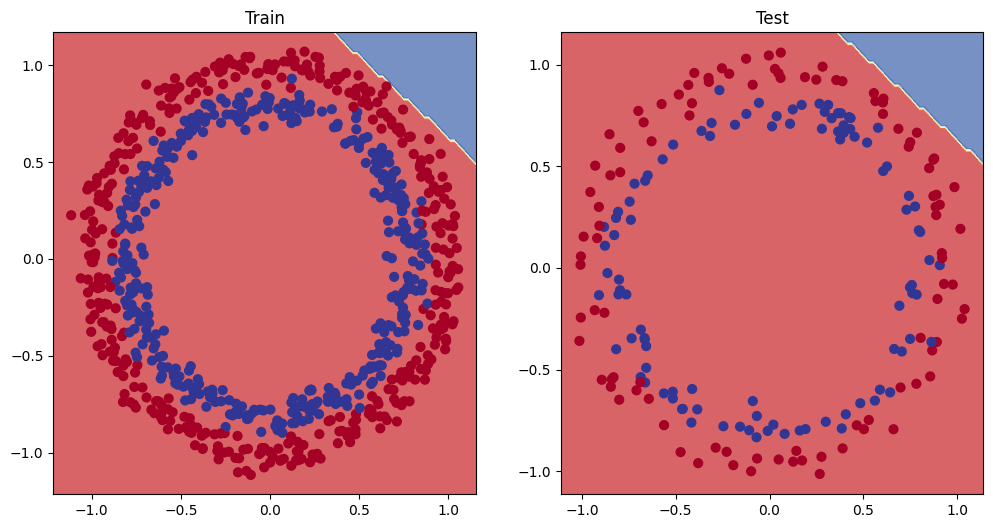

In [177]:
from utils.helper_functions import plot_decision_boundary ,plot_predictions

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)


In [178]:
X_train.shape, y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [208]:
"""we want to use activation functions to introduce non linearity"""

class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(2,10)
    self.layer2 = nn.Linear(10,10)
    self.layer3 = nn.Linear(10,1)
    self.relu   = nn.ReLU()

  def forward(self,x :torch.tensor) -> torch.tensor:
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))





In [209]:
model_2 = CircleModelV2().to(device)

model_2.state_dict()


OrderedDict([('layer1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1310

In [210]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs=200

# put the data to the target device -> "cuda"
X_train , y_train = X_train.to(device) , y_train.to(device)
X_test , y_test = X_test.to(device) , y_test.to(device)

for epoch in range(epochs):

  model_2.train()

  y_logits = model_2(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,y_train)
  acc = accuracy_function(y_train,y_pred)


  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_0.eval()

  with torch.inference_mode():
    test_logits = model_2(X_test).squeeze()

    test_pred = torch.round(torch.sigmoid(test_logits)) # from logits -> pred prob -> pred class labels

    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_function(y_test,test_pred)
      # logging .. print out what's happeing
  if epoch % 10 == 0:
      print(f"Epoch : {epoch} | Loss : {loss:.5f} | Train Accuracy : {acc:.2f} | Test Loss : {test_loss:.5f} | Test Accuracy : {test_acc:.2f}")



Epoch : 0 | Loss : 0.69295 | Train Accuracy : 0.50 | Test Loss : 0.69335 | Test Accuracy : 0.50
Epoch : 10 | Loss : 0.69295 | Train Accuracy : 0.50 | Test Loss : 0.69335 | Test Accuracy : 0.50
Epoch : 20 | Loss : 0.69295 | Train Accuracy : 0.50 | Test Loss : 0.69335 | Test Accuracy : 0.50
Epoch : 30 | Loss : 0.69295 | Train Accuracy : 0.50 | Test Loss : 0.69335 | Test Accuracy : 0.50
Epoch : 40 | Loss : 0.69295 | Train Accuracy : 0.50 | Test Loss : 0.69335 | Test Accuracy : 0.50
Epoch : 50 | Loss : 0.69295 | Train Accuracy : 0.50 | Test Loss : 0.69335 | Test Accuracy : 0.50
Epoch : 60 | Loss : 0.69295 | Train Accuracy : 0.50 | Test Loss : 0.69335 | Test Accuracy : 0.50
Epoch : 70 | Loss : 0.69295 | Train Accuracy : 0.50 | Test Loss : 0.69335 | Test Accuracy : 0.50
Epoch : 80 | Loss : 0.69295 | Train Accuracy : 0.50 | Test Loss : 0.69335 | Test Accuracy : 0.50
Epoch : 90 | Loss : 0.69295 | Train Accuracy : 0.50 | Test Loss : 0.69335 | Test Accuracy : 0.50
Epoch : 100 | Loss : 0.69295 | 

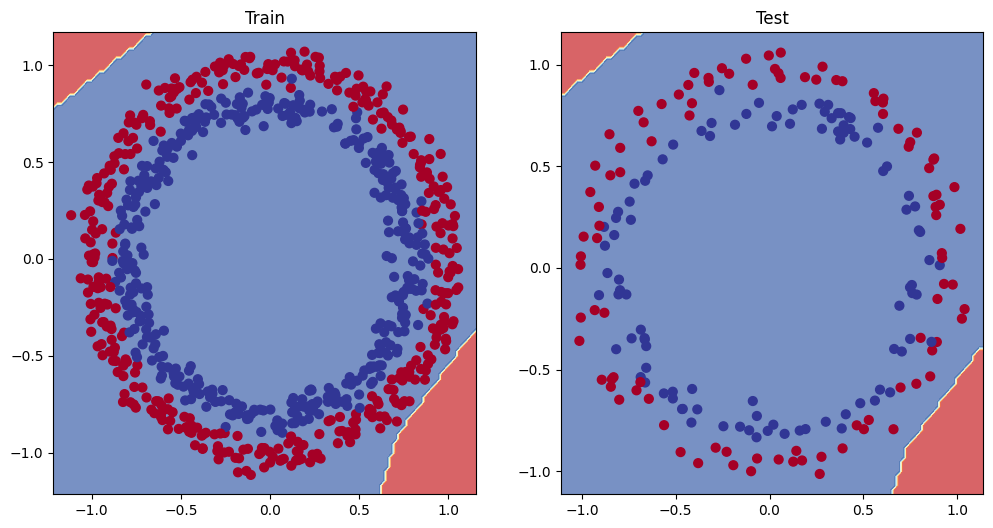

In [211]:
# plot decision boundaries for training and test set
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_2,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_2,X_test,y_test)

# Activation functions

In [212]:
x = torch.linspace(-15,15,100)
x

tensor([-15.0000, -14.6970, -14.3939, -14.0909, -13.7879, -13.4848, -13.1818,
        -12.8788, -12.5758, -12.2727, -11.9697, -11.6667, -11.3636, -11.0606,
        -10.7576, -10.4545, -10.1515,  -9.8485,  -9.5455,  -9.2424,  -8.9394,
         -8.6364,  -8.3333,  -8.0303,  -7.7273,  -7.4242,  -7.1212,  -6.8182,
         -6.5152,  -6.2121,  -5.9091,  -5.6061,  -5.3030,  -5.0000,  -4.6970,
         -4.3939,  -4.0909,  -3.7879,  -3.4848,  -3.1818,  -2.8788,  -2.5758,
         -2.2727,  -1.9697,  -1.6667,  -1.3636,  -1.0606,  -0.7576,  -0.4545,
         -0.1515,   0.1515,   0.4545,   0.7576,   1.0606,   1.3636,   1.6667,
          1.9697,   2.2727,   2.5758,   2.8788,   3.1818,   3.4848,   3.7879,
          4.0909,   4.3939,   4.6970,   5.0000,   5.3030,   5.6061,   5.9091,
          6.2121,   6.5152,   6.8182,   7.1212,   7.4242,   7.7273,   8.0303,
          8.3333,   8.6364,   8.9394,   9.2424,   9.5455,   9.8485,  10.1515,
         10.4545,  10.7576,  11.0606,  11.3636,  11.6667,  11.96

In [213]:
# ReLU

def relu(x):
  return torch.max(x,torch.tensor(0))

In [214]:
y = relu(x)
y

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.1515,  0.4545,  0.7576,  1.0606,  1.3636,  1.6667,
         1.9697,  2.2727,  2.5758,  2.8788,  3.1818,  3.4848,  3.7879,  4.0909,
         4.3939,  4.6970,  5.0000,  5.3030,  5.6061,  5.9091,  6.2121,  6.5152,
         6.8182,  7.1212,  7.4242,  7.7273,  8.0303,  8.3333,  8.6364,  8.9394,
         9.2424,  9.5455,  9.8485, 10.1515, 10.4545, 10.7576, 11.0606, 11.3636,
        11.6667, 11.9697, 12.2727, 12.5758, 12.8788, 13.1818, 13.4848, 13.7879,
        14.0909, 14.3939, 14.6970, 15.00

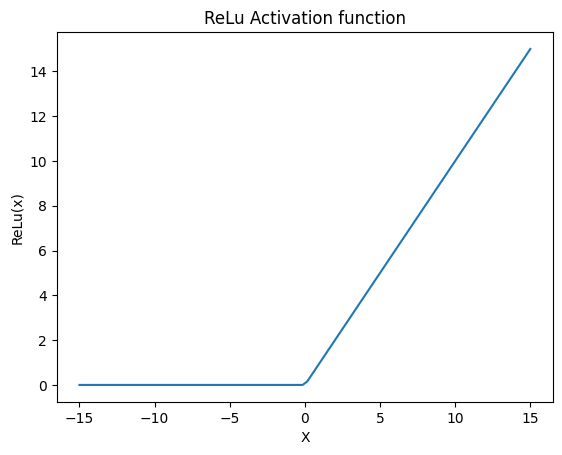

In [218]:
plt.plot(x.numpy(), y.numpy())
plt.title("ReLu Activation function")
plt.xlabel("X")
plt.ylabel("ReLu(x)")
plt.show()

In [221]:
# Tanh activation function

def tanh(x):
  return torch.exp(x)-torch.exp(-x) / torch.exp(x)+torch.exp(-x)


In [222]:
y = tanh(x)
y

tensor([-1.0686e+13, -5.8294e+12, -3.1799e+12, -1.7346e+12, -9.4624e+11,
        -5.1617e+11, -2.8157e+11, -1.5359e+11, -8.3784e+10, -4.5704e+10,
        -2.4931e+10, -1.3600e+10, -7.4186e+09, -4.0468e+09, -2.2075e+09,
        -1.2042e+09, -6.5687e+08, -3.5831e+08, -1.9545e+08, -1.0662e+08,
        -5.8157e+07, -3.1723e+07, -1.7304e+07, -9.4382e+06, -5.1479e+06,
        -2.8077e+06, -1.5313e+06, -8.3507e+05, -4.5535e+05, -2.4826e+05,
        -1.3533e+05, -7.3750e+04, -4.0178e+04, -2.1878e+04, -1.1906e+04,
        -6.4733e+03, -3.5155e+03, -1.9062e+03, -1.0313e+03, -5.5622e+02,
        -2.9873e+02, -1.5948e+02, -8.4394e+01, -4.4079e+01, -2.2548e+01,
        -1.1125e+01, -5.1069e+00, -1.9482e+00, -2.7187e-01,  6.6905e-01,
         1.2844e+00,  1.8073e+00,  2.3821e+00,  3.1145e+00,  4.1007e+00,
         5.4477e+00,  7.2885e+00,  9.7982e+00,  1.3212e+01,  1.7846e+01,
         2.4130e+01,  3.2647e+01,  4.4185e+01,  5.9811e+01,  8.0971e+01,
         1.0962e+02,  1.4842e+02,  2.0095e+02,  2.7

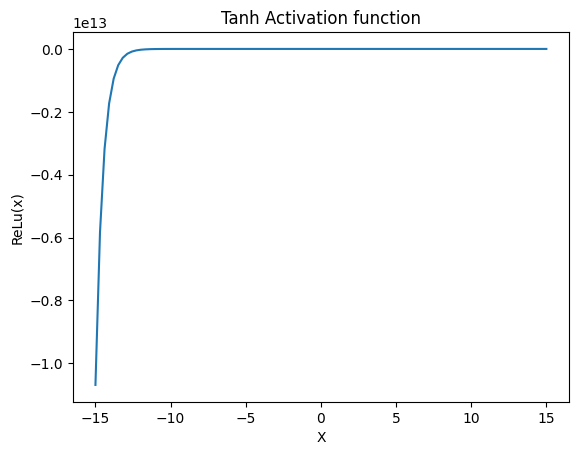

In [224]:
plt.plot(x.numpy(), y.numpy())
plt.title("Tanh Activation function")
plt.xlabel("X")
plt.ylabel("ReLu(x)")
plt.show()

In [225]:
# sigmoid activation function

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

x = torch.linspace(-15,15,100)
y = sigmoid(x)
y

tensor([3.0590e-07, 4.1418e-07, 5.6078e-07, 7.5927e-07, 1.0280e-06, 1.3919e-06,
        1.8846e-06, 2.5516e-06, 3.4547e-06, 4.6776e-06, 6.3332e-06, 8.5749e-06,
        1.1610e-05, 1.5719e-05, 2.1283e-05, 2.8816e-05, 3.9015e-05, 5.2824e-05,
        7.1521e-05, 9.6833e-05, 1.3110e-04, 1.7750e-04, 2.4031e-04, 3.2534e-04,
        4.4045e-04, 5.9626e-04, 8.0714e-04, 1.0925e-03, 1.4786e-03, 2.0010e-03,
        2.7073e-03, 3.6621e-03, 4.9518e-03, 6.6929e-03, 9.0404e-03, 1.2201e-02,
        1.6449e-02, 2.2142e-02, 2.9746e-02, 3.9856e-02, 5.3212e-02, 7.0715e-02,
        9.3407e-02, 1.2242e-01, 1.5887e-01, 2.0365e-01, 2.5719e-01, 3.1917e-01,
        3.8828e-01, 4.6219e-01, 5.3781e-01, 6.1172e-01, 6.8083e-01, 7.4281e-01,
        7.9635e-01, 8.4113e-01, 8.7758e-01, 9.0659e-01, 9.2928e-01, 9.4679e-01,
        9.6014e-01, 9.7025e-01, 9.7786e-01, 9.8355e-01, 9.8780e-01, 9.9096e-01,
        9.9331e-01, 9.9505e-01, 9.9634e-01, 9.9729e-01, 9.9800e-01, 9.9852e-01,
        9.9891e-01, 9.9919e-01, 9.9940e-

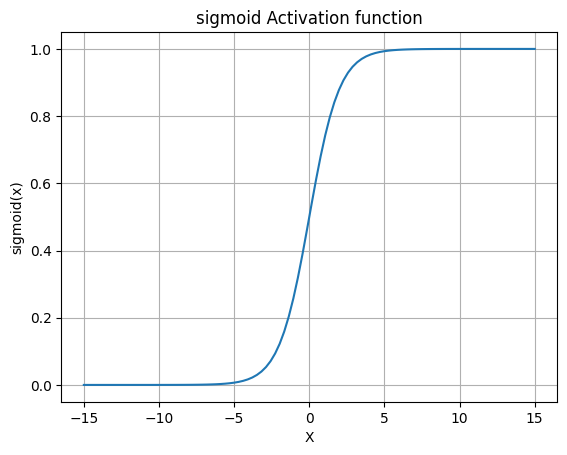

In [226]:
plt.plot(x.numpy(), y.numpy())
plt.title("sigmoid Activation function")
plt.xlabel("X")
plt.ylabel("sigmoid(x)")
plt.grid(True)
plt.show()